<a href="https://colab.research.google.com/github/deenyse/BC-Collector/blob/main/Copy_of_UASS_6_18_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analýza dynamických sítí

> Cílem cvičení je vyzkoušet si analyzovat dynamické sítě s využitím poznatků z minulých cvičení.


## Část 1: Struktury v sítí

1. Sítě
  - Emailová síť [Emailova sit](https://homel.vsb.cz/~pap0081/email_network.zip)
  - Vyberte si jednu síť síť https://homel.vsb.cz/~kud007/lectures/uass_04.pdf

2. Rozdělte síť alespoň na 5 statických snímků.

3. Analyzujte síť, výstupem by měl být dokument, kde shrnete získané poznatky v rozdílech mezi snímky
  - Zjistěte, jak se v čase (v jednotlivých snímcích) mění průměrný stupeň a průměrný vážený stupeň sítě.
  - Zjistěte, jak se v čase mění počet komunit a souvislých komponent, a jak se mění průměrná a maximální velikost komunity.
  - Vizualizujte jednotlivé sítě a popřemýšlejte, jaké typické vzorce se v sítích vyskytují a v jakém množství (kliky a hvězdy, malé souvislé komponenty a outliers apod.).
  - Ve vizualizaci najděte nějaké vrcholy s vysokým stupněm resp. s vysokým váženým stupněm a popřemýšlejte, proč se v některých případech nejedná o tytéž vrcholy a zkuste zformulovat, proč tomu tak je.
  - V alespoň jedné síti vyberte alespoň jeden vrchol, který má na posledním snímku vysoký stupeň resp. vážený stupeň a na něm ukažte, jak se vyvíjí čase (postupné změny ve stupni resp. váženém stupni, velikost komunity popř. komponenty, do které patří).

In [10]:
# Nacteni site

import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community

G = nx.Graph()
delimiter = ','

with open("email-dnc.edges", "r") as f:
    for line in f:
        u, v, ts = line.strip().split(delimiter)
        ts = float(ts)
        dt = datetime.fromtimestamp(ts)
        G.add_edge(u, v, timestamp=dt)



In [6]:
print(G)

Graph with 1892 nodes and 4466 edges


In [7]:
import random
import networkx as nx

def find_components(G):
    return list(nx.connected_components(G))


def find_cliques(G, min_size=3):
    clique_nodes = set()
    for clique in nx.find_cliques(G):
        if len(clique) >= min_size:
            clique_nodes.update(clique)
    return clique_nodes


def find_stars(G, degree_percentile=80, leaf_density_threshold=0.2):
    degrees = [G.degree(n) for n in G]
    min_degree = np.percentile(degrees, degree_percentile)
    star_nodes = set()
    for node in G:
        if G.degree(node) < min_degree:
            continue
        neighbors = list(G.neighbors(node))
        if len(neighbors) < 3:
            continue
        if nx.density(G.subgraph(neighbors)) <= leaf_density_threshold:
            star_nodes.add(node)
    return star_nodes



In [8]:
def color_nodes(G, nodes, color, node_type=None):
    for n in nodes:
        if n not in G.nodes:
            continue
        G.nodes[n]["color"] = color
        if node_type:
            G.nodes[n]["type"] = node_type


def export_to_gephi(G: nx.Graph, path: str = "graph_colored.gexf"):
    nx.write_gexf(G, path)



In [11]:

    # Detect structures
    clique_nodes = find_cliques(G, min_size=4)
    star_nodes = find_stars(G, degree_percentile=80, leaf_density_threshold=0.2)
    components = list(find_components(G))

    # Initialize default color/type
    nx.set_node_attributes(G, "default", "type")
    nx.set_node_attributes(G, "gray", "color")

    # Color by structure type
    color_nodes(G, clique_nodes, "#ff0000", "clique")
    color_nodes(G, near_nodes, "#ff9900", "near_clique")
    color_nodes(G, star_nodes, "#00ccff", "star")

    # Print summary
    print(f"Total nodes: {G.number_of_nodes()}")
    print(f"Components: {len(components)}")
    print(f"Clique nodes: {len(clique_nodes)}")
    print(f"Near-clique nodes: {len(near_nodes)}")
    print(f"Star nodes: {len(star_nodes)}")



NameError: name 'near_nodes' is not defined

In [12]:
import networkx as nx
from collections import defaultdict
from datetime import datetime, timedelta

def split_graph_into_snapshots_datetime(G: nx.Graph, time_attr: str, num_snapshots: int,
                                        start_time=None, end_time=None, attr_type='edge'):
    times = []
    if attr_type == 'edge':
        for _, _, data in G.edges(data=True):
            if time_attr in data:
                times.append(data[time_attr])
    elif attr_type == 'node':
        for _, data in G.nodes(data=True):
            if time_attr in data:
                times.append(data[time_attr])
    else:
        raise ValueError("attr_type must be 'edge' or 'node'")

    if not times:
        raise ValueError("No time attributes found in the graph.")

    start = start_time if start_time else min(times)
    end = end_time if end_time else max(times)
    print(start, end)
    total_seconds = (end - start).total_seconds()
    interval_seconds = total_seconds / num_snapshots

    for i in range(num_snapshots):
      print(datetime.fromtimestamp(start.timestamp() + interval_seconds * i))

    def get_snapshot_index(t):
        delta_sec = (t - start).total_seconds()
        idx = int(delta_sec / interval_seconds)
        return max(0, min(idx, num_snapshots - 1))

    graph_type = nx.DiGraph if G.is_directed() else nx.Graph
    snapshots = defaultdict(graph_type)

    if attr_type == 'edge':
        for u, v, data in G.edges(data=True):
            if time_attr in data:
                idx = get_snapshot_index(data[time_attr])
                snapshots[idx].add_edge(u, v, **data)

        for idx, H in snapshots.items():
            used_nodes = set(H.nodes())
            for n in used_nodes:
                if n in G.nodes:
                    H.nodes[n].update(G.nodes[n])

            iso = list(nx.isolates(H))
            H.remove_nodes_from(iso)

    elif attr_type == 'node':
        for node, data in G.nodes(data=True):
            if time_attr in data:
                idx = get_snapshot_index(data[time_attr])
                snapshots[idx].add_node(node, **data)

        for idx, H in snapshots.items():
            for u, v, data in G.edges(data=True):
                if u in H and v in H:
                    H.add_edge(u, v, **data)

            iso = list(nx.isolates(H))
            H.remove_nodes_from(iso)

    return dict(snapshots)

In [13]:
for k,v in split_graph_into_snapshots_datetime(G, 'timestamp', 5).items():
  print(v)

2013-09-16 02:30:33 2016-05-25 06:07:30
2013-09-16 02:30:33
2014-03-31 12:49:56.400000
2014-10-13 23:09:19.800000
2015-04-28 09:28:43.200000
2015-11-10 19:48:06.600000
Graph with 1790 nodes and 4308 edges
Graph with 133 nodes and 137 edges
Graph with 24 nodes and 20 edges
Graph with 2 nodes and 1 edges


In [14]:
snapshots = split_graph_into_snapshots_datetime(G, 'timestamp', 5)

print(f"Successfully created {len(snapshots)} snapshots.")

2013-09-16 02:30:33 2016-05-25 06:07:30
2013-09-16 02:30:33
2014-03-31 12:49:56.400000
2014-10-13 23:09:19.800000
2015-04-28 09:28:43.200000
2015-11-10 19:48:06.600000
Successfully created 4 snapshots.


In [15]:
# 3. Analyze the network
print(f"{'Snapshot':<10} | {'Avg Degree':<12} | {'Components':<12} | {'Communities':<12} | {'Avg Com Size':<12}")
print("-" * 70)

# last snapshot key to use it later
last_snapshot_key = sorted(snapshots.keys())[-1]

for key in sorted(snapshots.keys()):
    sub_graph = snapshots[key]

    if sub_graph.number_of_nodes() == 0:
        print(f"{key:<10} | {'0':<12} | {'0':<12} | {'0':<12} | {'0':<12}")
        continue

    degrees = [val for (node, val) in sub_graph.degree()]
    avg_degree = sum(degrees) / sub_graph.number_of_nodes()

    comps = find_components(sub_graph)
    num_components = len(comps)

    coms = list(community.greedy_modularity_communities(sub_graph))
    num_communities = len(coms)

    com_sizes = [len(c) for c in coms]
    if len(com_sizes) > 0:
        avg_com_size = sum(com_sizes) / len(com_sizes)
        max_com_size = max(com_sizes)
    else:
        avg_com_size = 0
        max_com_size = 0

    print(f"{key:<10} | {avg_degree:<12.4f} | {num_components:<12} | {num_communities:<12} | {avg_com_size:<12.2f}")

Snapshot   | Avg Degree   | Components   | Communities  | Avg Com Size
----------------------------------------------------------------------
0          | 1.0000       | 1            | 1            | 2.00        
2          | 1.6667       | 5            | 6            | 4.00        
3          | 2.0602       | 9            | 15           | 8.87        
4          | 4.8134       | 37           | 55           | 32.55       



--- Analysis of Snapshot 0 ---
Found 0 nodes in Cliques (size >= 4)
Found 0 nodes in Stars


/tmp/ipython-input-2998229406.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


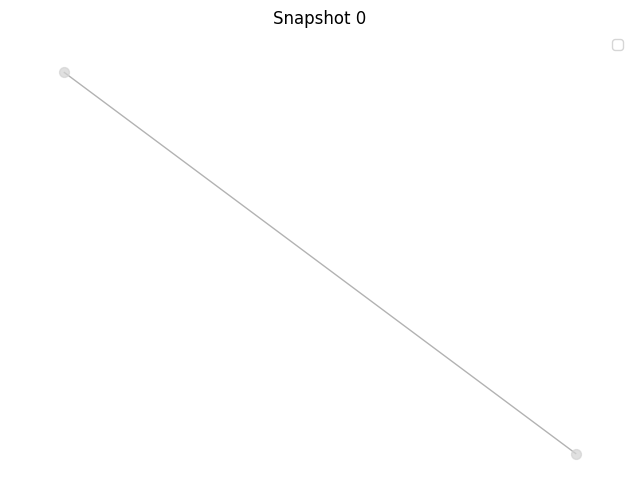


--- Analysis of Snapshot 2 ---
Found 0 nodes in Cliques (size >= 4)
Found 2 nodes in Stars


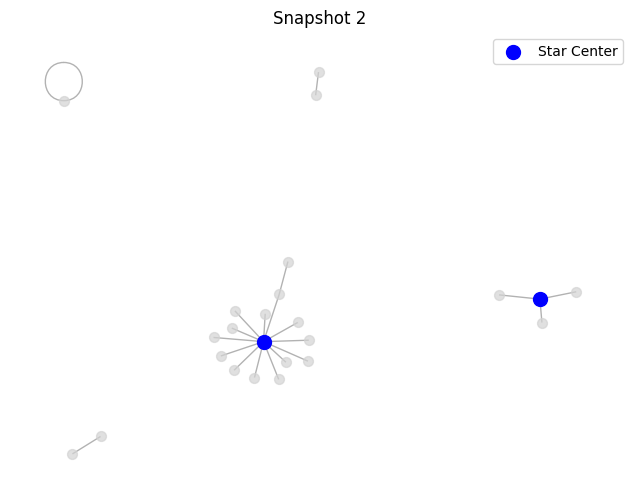


--- Analysis of Snapshot 3 ---
Found 0 nodes in Cliques (size >= 4)
Found 12 nodes in Stars


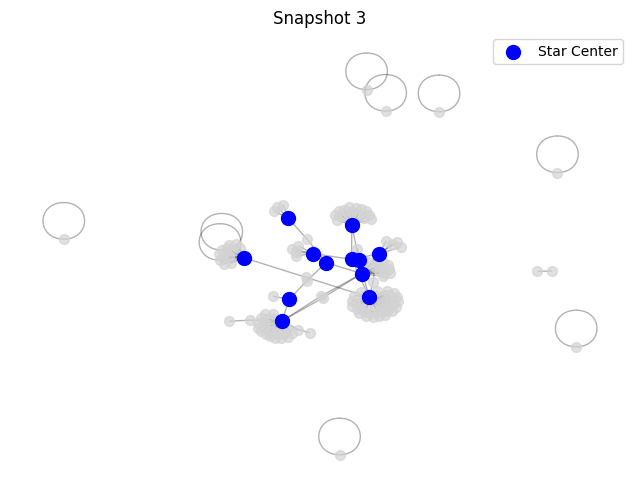


--- Analysis of Snapshot 4 ---
Found 279 nodes in Cliques (size >= 4)
Found 20 nodes in Stars


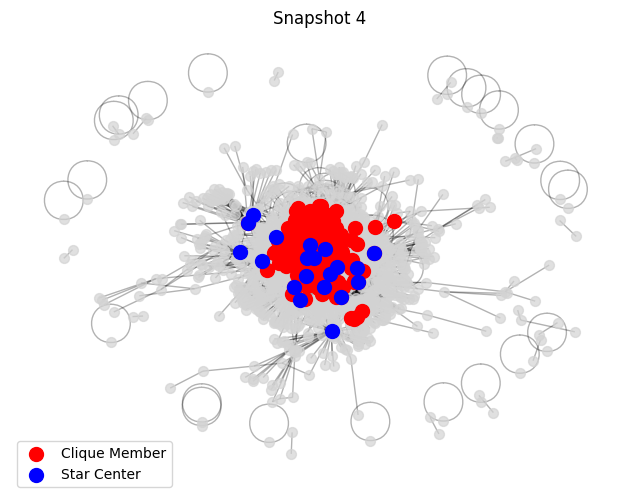

In [16]:

for key in sorted(snapshots.keys()):
    sub_graph = snapshots[key]

    if sub_graph.number_of_nodes() < 2:
        continue
    print(f"\n--- Analysis of Snapshot {key} ---")

    clique_nodes = find_cliques(sub_graph, min_size=4)
    star_nodes = find_stars(sub_graph, degree_percentile=90, leaf_density_threshold=0.1)

    print(f"Found {len(clique_nodes)} nodes in Cliques (size >= 4)")
    print(f"Found {len(star_nodes)} nodes in Stars")

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(sub_graph, seed=42)

    nx.draw_networkx_nodes(sub_graph, pos, node_size=50, node_color='lightgray', alpha=0.7)

    if clique_nodes:
        nx.draw_networkx_nodes(sub_graph, pos, nodelist=list(clique_nodes), node_size=100, node_color='red', label='Clique Member')

    if star_nodes:
        nx.draw_networkx_nodes(sub_graph, pos, nodelist=list(star_nodes), node_size=100, node_color='blue', label='Star Center')

    nx.draw_networkx_edges(sub_graph, pos, alpha=0.3)
    plt.title(f"Snapshot {key}")
    plt.legend()
    plt.axis('off')
    plt.show()

In [17]:
# 4. & 5. High degree nodes and Evolution

# Helper to find top node in a graph
def get_top_node(graph):
    if len(graph) == 0:
        return None, 0
    # Sort nodes by degree
    degree_list = sorted(graph.degree, key=lambda x: x[1], reverse=True)
    return degree_list[0] # Returns (node_id, degree)

# A. Find top node in each snapshot
print("Top Degree Node in each snapshot:")
for key in sorted(snapshots.keys()):
    node, deg = get_top_node(snapshots[key])
    print(f"Snapshot {key}: Node {node} (Degree {deg})")

print("\n" + "="*30 + "\n")

# B. Select the top node from the LAST snapshot and track it backwards
last_graph = snapshots[last_snapshot_key]
target_node, target_deg = get_top_node(last_graph)

if target_node:
    print(f"Tracking Node '{target_node}' (Winner of last snapshot) through time:\n")

    for key in sorted(snapshots.keys()):
        sg = snapshots[key]

        # Check if node exists in this snapshot
        if target_node in sg:
            d = sg.degree(target_node)

            # Find which community it belongs to
            # (We run community detection again briefly to find the specific community)
            coms = list(community.greedy_modularity_communities(sg))
            com_index = -1
            com_size = 0
            for i, c in enumerate(coms):
                if target_node in c:
                    com_index = i
                    com_size = len(c)
                    break

            print(f"Snapshot {key}: Degree = {d}, Community Size = {com_size}")
        else:
            print(f"Snapshot {key}: Node not present")
else:
    print("Graph is empty, cannot track nodes.")

Top Degree Node in each snapshot:
Snapshot 0: Node 547 (Degree 1)
Snapshot 2: Node 1159 (Degree 13)
Snapshot 3: Node 1159 (Degree 35)
Snapshot 4: Node 1874 (Degree 402)


Tracking Node '1874' (Winner of last snapshot) through time:

Snapshot 0: Node not present
Snapshot 2: Node not present
Snapshot 3: Degree = 2, Community Size = 1
Snapshot 4: Degree = 402, Community Size = 381
